<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [146]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [147]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-08-29 15:18:39--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.004s  

2019-08-29 15:18:39 (5.59 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [148]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [149]:
df.shape

(346, 10)

### Convert to date time object 

In [150]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [151]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [152]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

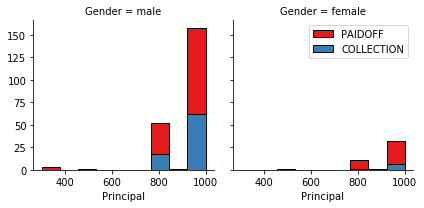

In [153]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

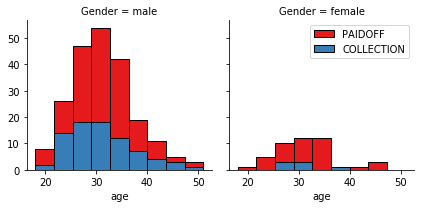

In [154]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

### Analyzing month of the year people get the loan

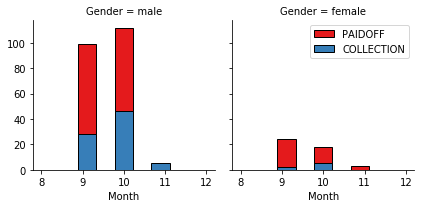

In [155]:
df['Month'] = df.due_date.dt.month
bins = np.linspace(df.Month.min()-1, df.Month.max()+1, 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Month', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

In [156]:
# there is higher possibility that people pay off the loan in 9th or 10th month than paying it in other months

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

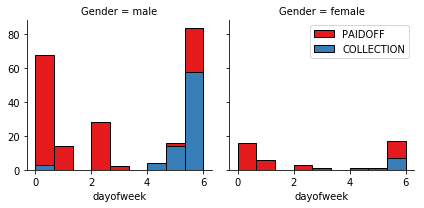

In [157]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [158]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,Month,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,10,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,10,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,9,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,10,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,10,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [159]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [160]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,Month,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,10,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,10,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,9,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,10,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,10,4,1


## One Hot Encoding  
#### How about education?

In [161]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [162]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [163]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [164]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [165]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [166]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# split, train, test data

In [167]:
# import libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate as cross_validation
import sklearn.model_selection as model_selection
from sklearn.model_selection import KFold
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score

In [168]:
# X : set of features
# y : labels (ie: values for loan_status)
# X : normalized data
# random_state : finite value so that the test results are reproducable
# shuffle=True to iterate over the entire dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, shuffle=True)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)
# print ("X_train: ", X_train)
# print ("y_train: ", y_train)
# print("X_test: ", X_test)
# print ("y_test: ", y_test)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [169]:
# using the KFold( ) function to split the dataset into n consecutive folds.
# the shape of the train and test sets are getting modified: hence not using it
# kf = KFold(n_splits=5, shuffle=True)
# X = np.array(X)
# y = np.array(y)
# for train_index, test_index in kf.split(X):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
    
# print ('Train set:', X_train.shape,  y_train.shape)
# print ('Test set:', X_test.shape,  y_test.shape)
# print ("X_train: ", X_train)
# print ("y_train: ", y_train)
# print("X_test: ", X_test)
# print ("y_test: ", y_test)

# a dictionary for keeping all scores of the classifiers
trainScores={}

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [170]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [171]:
Ks = 12
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfusionMx = []

cv_scores = []
classification_reports = []
predict_vals = []

# finding the optimal number of clusters, Knnbest
for n in range(1,Ks):    
    # Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    cv_scores = cross_val_score(neigh, X, y, cv=10)
    # print each cv score (accuracy) and average them
    # print(cv_scores)
    # print('cv_scores mean:{}'.format(np.mean(cv_scores)))
    yhat = neigh.predict(X_test)
    predict_vals = neigh.predict(X_test)
    # print(neigh.predict(X_test).shape)
    # print(neigh.predict_proba(X_test).shape)    
    ConfusionMx = confusion_matrix(y_test, yhat)
    classification_reports = classification_report(y_test, yhat)
    # print(classification_reports)
    # print(neigh.score(X_test, y_test))
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat) 
    std_acc[n-1] = np.std(yhat == y_test)/np.sqrt(yhat.shape[0])

mean_acc
# print(mean_acc)
knnbest = mean_acc.argmax()+1
print("Best Accuracy is with neighbor ",knnbest)
print("Best Accuracy is ",mean_acc.max())

Best Accuracy is with neighbor  7
Best Accuracy is  0.7857142857142857


In [172]:
# verifying the dimensions of the various variables
print ('Shape of feature train set, X_train: ', X_train.shape)
print ('Shape of target train set, y_train: ', y_train.shape)
print ('Shape of feature test set, X_test: ', X_test.shape)
print ('Shape of target test set, y_test: ', y_test.shape)
print ('Shape of target predicted set, yhat: ', yhat.shape)
print ('Shape of mean accumulator, mean_acc: ', mean_acc.shape)
print ('Shape of standard deviation accumulator, std_acc:', std_acc.shape)
print ('Shape of CV scores, cv_scores: ', cv_scores.shape)
print ('Shape of predicted values, predict_vals: ', predict_vals.shape)
print ('Shape of Confusion Matrix, ConfusionMx: ',ConfusionMx.shape)

Shape of feature train set, X_train:  (276, 8)
Shape of target train set, y_train:  (276,)
Shape of feature test set, X_test:  (70, 8)
Shape of target test set, y_test:  (70,)
Shape of target predicted set, yhat:  (70,)
Shape of mean accumulator, mean_acc:  (11,)
Shape of standard deviation accumulator, std_acc: (11,)
Shape of CV scores, cv_scores:  (10,)
Shape of predicted values, predict_vals:  (70,)
Shape of Confusion Matrix, ConfusionMx:  (2, 2)


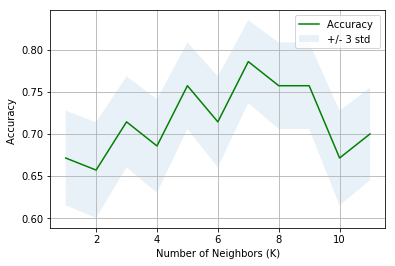

In [173]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3 std'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.grid(True)
plt.show()

In [174]:
print(classification_reports)

              precision    recall  f1-score   support

  COLLECTION       0.29      0.27      0.28        15
     PAIDOFF       0.80      0.82      0.81        55

   micro avg       0.70      0.70      0.70        70
   macro avg       0.54      0.54      0.54        70
weighted avg       0.69      0.70      0.70        70



In [175]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

The best accuracy was with 0.7857142857142857 with k= 7


# Build the KNN model with k = knnbest

In [176]:
k = knnbest

# Train Model and Predict  
neigh_best = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat_best = neigh_best.predict(X_test)
yhat_best[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [177]:
# model accuracy
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh_best.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_best))

Train set Accuracy:  0.8079710144927537
Test set Accuracy:  0.7857142857142857


In [178]:
# classification report
print(classification_report(y_test, yhat_best))


              precision    recall  f1-score   support

  COLLECTION       0.50      0.40      0.44        15
     PAIDOFF       0.84      0.89      0.87        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.67      0.65      0.66        70
weighted avg       0.77      0.79      0.78        70



In [179]:
# # confusion matrix
print(confusion_matrix(y_test, yhat_best))

[[ 6  9]
 [ 6 49]]


In [180]:
# F1 score
f1_score(y_test, yhat_best, average='weighted')

0.7766540244416351

In [181]:
# Jaccard Similarity Score
jaccard_similarity_score(y_test, yhat_best)

0.7857142857142857

# Decision Tree

In [182]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

In [183]:
# Using the original train_test_split from above in Line 70
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.2, random_state=3)
print ('Train set:', X_trainset.shape,  y_trainset.shape)
print ('Test set:', X_testset.shape,  y_testset.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [184]:
# Create instance of the decision tree
LoanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
LoanTree # it shows the default parameters

#Fit data
LoanTree.fit(X_trainset,y_trainset)
print(LoanTree)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [185]:
yhat = LoanTree.predict(X_test)
print(yhat)

['COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'PAIDOFF' 'COLLECTION' 'COLLECTION'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'COLLECTION' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF']


In [186]:
# packages for visualization
# !conda install -c conda-forge pydotplus -y
# !conda install -c conda-forge python-graphviz -y

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'PAIDOFF']
DecisionTrees's Accuracy:  0.5857142857142857


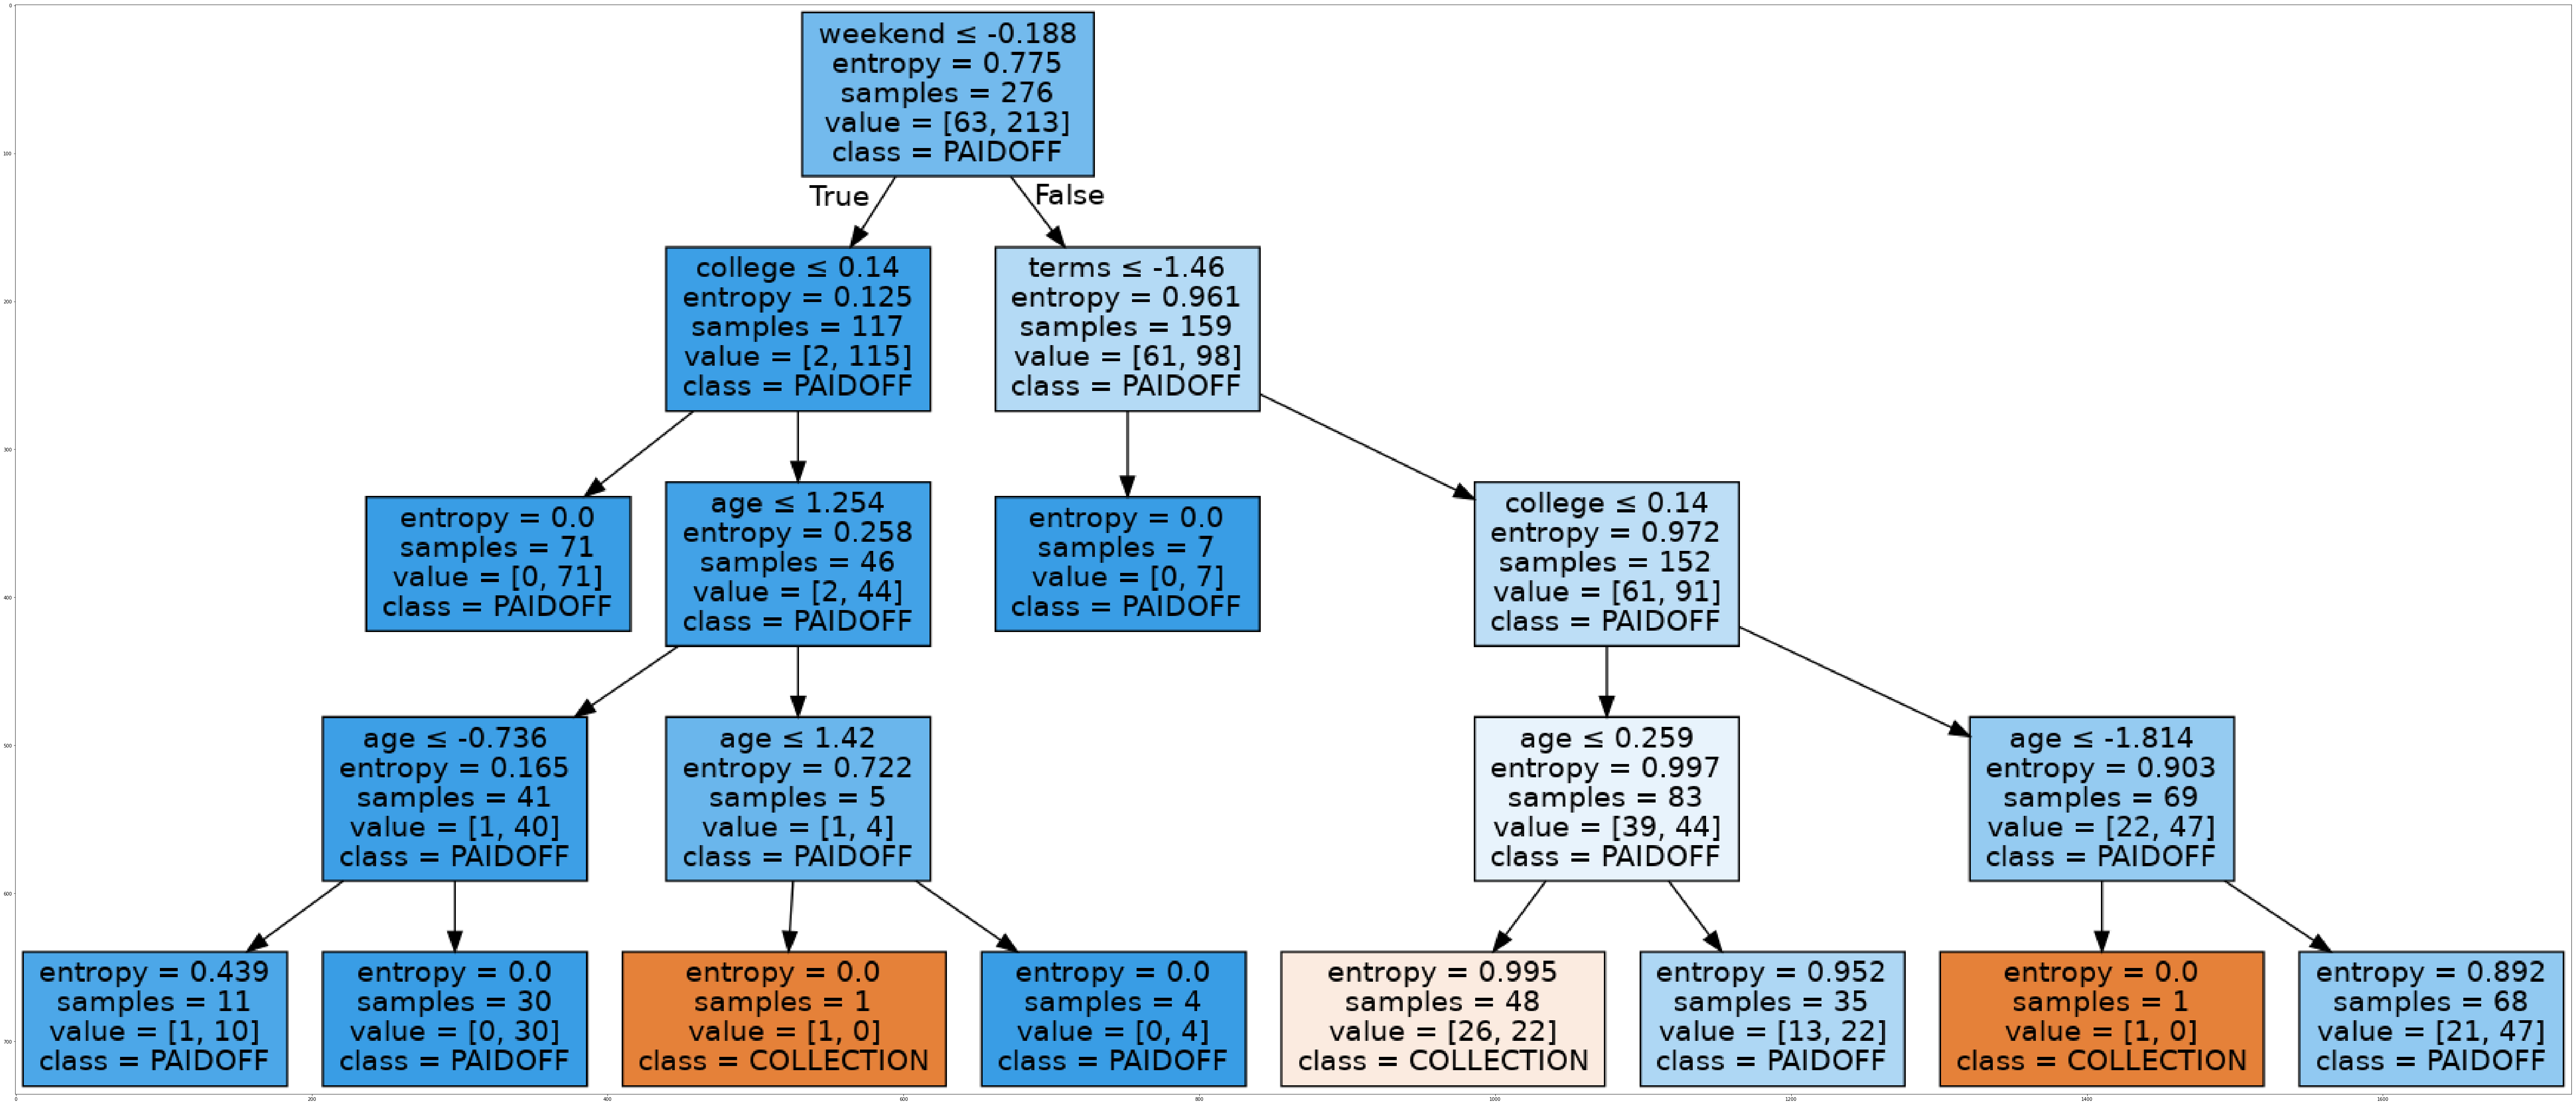

In [187]:
predTree = LoanTree.predict(X_testset)
print (predTree [0:5])
print (y_testset [0:5])

#EVALUATION
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline

dot_data = StringIO()
filename = "Loan.png"
featureNames = Feature.columns # check
# featureNames = df.columns[0:8]
targetNames = df["loan_status"].unique().tolist()
out=tree.export_graphviz(LoanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

In [188]:
# Calculating the train and test accuracy
print("Train set Accuracy: ", metrics.accuracy_score(y_train, LoanTree.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.7608695652173914
Test set Accuracy:  0.7142857142857143


In [189]:
# confusion matrix and classification report
print(classification_report(y_test, yhat))
print(confusion_matrix(y_test, yhat))

              precision    recall  f1-score   support

  COLLECTION       0.27      0.20      0.23        15
     PAIDOFF       0.80      0.85      0.82        55

   micro avg       0.71      0.71      0.71        70
   macro avg       0.53      0.53      0.53        70
weighted avg       0.68      0.71      0.70        70

[[ 3 12]
 [ 8 47]]


In [190]:
from sklearn.metrics import f1_score
# Calculate the F1 score
f1_score(y_test, yhat, average='weighted')

0.697320223636013

In [191]:
# Jaccard Similarity Score
jaccard_similarity_score(y_test, yhat)

0.7142857142857143

# Support Vector Machine

In [192]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [193]:
# Import the library for SVM Classifier
from sklearn import svm

# Build a SVM Classifier with a Radial base Function Kernel
loansvm1 = svm.SVC(kernel='rbf').fit(X_train, y_train)
yhat1 = loansvm1.predict(X_test)
svm_r = metrics.accuracy_score(y_test, yhat1)
print('\nClassification report and confusion matrix for a Radial base Function Kernel\n')
print (classification_report(y_test, yhat1))
print(confusion_matrix(y_test, yhat1))
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loansvm1.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat1))

# Build a SVM Classifier with a Linear Kernel
loansvm2 = svm.SVC(kernel='linear').fit(X_train, y_train)
yhat2 = loansvm2.predict(X_test)
svm_l = metrics.accuracy_score(y_test, yhat2)
print('\nClassification report and confusion matrix for a Linear Kernel\n')
print (classification_report(y_test, yhat2))
print(confusion_matrix(y_test, yhat2))
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loansvm2.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat2))

# Build a SVM Classifier with a Polynomial Kernel
loansvm3 = svm.SVC(kernel='poly').fit(X_train, y_train)
yhat3 = loansvm3.predict(X_test)
svm_p = metrics.accuracy_score(y_test, yhat3)
print('\nClassification report and confusion matrix for a Polynomial Kernel\n')
print (classification_report(y_test, yhat3))
print(confusion_matrix(y_test, yhat3))
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loansvm3.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat3))

# Build a SVM Classifier with a Sigmoid Kernel
loansvm4 = svm.SVC(kernel='sigmoid').fit(X_train, y_train)
yhat4 = loansvm4.predict(X_test)
svm_s = metrics.accuracy_score(y_test, yhat4)
print('\nClassification report and confusion matrix for a Sigmoid Kernel\n')
print (classification_report(y_test, yhat4))
print(confusion_matrix(y_test, yhat4))
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loansvm4.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat4))

print("\nAccuracy Score for {} : {}\nAccuracy Score for {} : {}\nAccuracy Score for {} : {}\n \Accuracy Score for {} : {} : ".format('Radial base Function Kernel', svm_r, 'Linear Kernel', svm_l, 'Polynomial Kernel', svm_p, 'Sigmoid Kernel', svm_s))
print("\nThe kernel with the highest accuracy is: {}".format(max(svm_r,svm_l,svm_p, svm_s)))


Classification report and confusion matrix for a Radial base Function Kernel

              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

   micro avg       0.74      0.74      0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

[[ 4 11]
 [ 7 48]]
Train set Accuracy:  0.782608695652174
Test set Accuracy:  0.7428571428571429

Classification report and confusion matrix for a Linear Kernel

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        15
     PAIDOFF       0.79      1.00      0.88        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

[[ 0 15]
 [ 0 55]]
Train set Accuracy:  0.7427536231884058
Test set Accuracy:  0.7857142857142857

Classi

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

In [194]:
# # Calculate the f1 score
f1_score_svm_r = f1_score(y_test, yhat1, average='weighted')
f1_score_svm_l = f1_score(y_test, yhat2, average='weighted')
f1_score_svm_p = f1_score(y_test, yhat3, average='weighted')
f1_score_svm_s = f1_score(y_test, yhat4, average='weighted')

print("\nF1 Score for {} : {}\nF1 Score for {} : {}\nF1 Score for {} : {}\nF1 Score for {} : {} : ".format('Radial base Function Kernel', f1_score_svm_r, 'Linear Kernel', f1_score_svm_l, 'Polynomial Kernel', f1_score_svm_p, 'Sigmoid Kernel', f1_score_svm_s))




F1 Score for Radial base Function Kernel : 0.7275882012724117
F1 Score for Linear Kernel : 0.6914285714285714
F1 Score for Polynomial Kernel : 0.7064793130366899
F1 Score for Sigmoid Kernel : 0.6892857142857144 : 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [195]:
#Calculate the Jaccard index
jaccard_similarity_score_svm_r = jaccard_similarity_score(y_test, yhat1)
jaccard_similarity_score_svm_l = jaccard_similarity_score(y_test, yhat2)
jaccard_similarity_score_svm_p = jaccard_similarity_score(y_test, yhat3)
jaccard_similarity_score_svm_s = jaccard_similarity_score(y_test, yhat4)

print("\nF1 Score for {} : {}\nF1 Score for {} : {}\nF1 Score for {} : {}\nF1 Score for {} : {} : ".format('Radial base Function Kernel', jaccard_similarity_score_svm_r, 'Linear Kernel', jaccard_similarity_score_svm_l, 'Polynomial Kernel', jaccard_similarity_score_svm_p, 'Sigmoid Kernel', jaccard_similarity_score_svm_s))



F1 Score for Radial base Function Kernel : 0.7428571428571429
F1 Score for Linear Kernel : 0.7857142857142857
F1 Score for Polynomial Kernel : 0.7714285714285715
F1 Score for Sigmoid Kernel : 0.7428571428571429 : 


In [196]:
# The SVM with a linear kernel has the highest accuracy

# Logistic Regression

In [197]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [198]:
# Liblinear logistic regression model
loanlr1 = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat1 = loanlr1.predict(X_test)
print('\nClassification report and confusion matrix for Liblinear logestic regression model\n')
print (classification_report(y_test, yhat1))
print(confusion_matrix(y_test, yhat1))

# Stochastic Average Gradient logistic regression model
loanlr2 = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
yhat2 = loanlr2.predict(X_test)
print('\nClassification report and confusion matrix for Stochastic Average Gradient logestic regression model\n')
print (classification_report(y_test, yhat2))
print(confusion_matrix(y_test, yhat2))

# SAGA: Fast Incremental Gradient Method With Support for Non-Strongly Convex Composite Objectives logistic regression model
loanlr3 = LogisticRegression(C=0.01, solver='saga').fit(X_train,y_train)
yhat3 = loanlr3.predict(X_test)
print('\nClassification report and confusion matrix for SAGA regression model\n')
print (classification_report(y_test, yhat3))
print(confusion_matrix(y_test, yhat3))

# Newton-CG logistic regression model
loanlr4 = LogisticRegression(C=0.01, solver='newton-cg').fit(X_train,y_train)
yhat4 = loanlr4.predict(X_test)
print('\nClassification report and confusion matrix for Newton-CG regression model\n')
print (classification_report(y_test, yhat4))
print(confusion_matrix(y_test, yhat4))

# LBFGS solver based logistic regression model
loanlr5 = LogisticRegression(C=0.01, solver='lbfgs').fit(X_train,y_train)
yhat5 = loanlr5.predict(X_test)
print('\nClassification report and confusion matrix for LBFGS solver based regression model\n')
print (classification_report(y_test, yhat5))
print(confusion_matrix(y_test, yhat5))



Classification report and confusion matrix for Liblinear logestic regression model

              precision    recall  f1-score   support

  COLLECTION       0.18      0.13      0.15        15
     PAIDOFF       0.78      0.84      0.81        55

   micro avg       0.69      0.69      0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70

[[ 2 13]
 [ 9 46]]

Classification report and confusion matrix for Stochastic Average Gradient logestic regression model

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        15
     PAIDOFF       0.79      1.00      0.88        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

[[ 0 15]
 [ 0 55]]

Classification report and confusion matrix for SAGA regression model

              precision    recall  f1-score   sup

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

In [199]:
# Accuracy reports
print('\nLiblinear logistic Regression')
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loanlr1.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat1))

print('\nStochastic Average Gradient Logistic Regression')
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loanlr2.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat2))

print('\nSAGA: Fast Incremental Gradient Method')
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loanlr3.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat3))

print('\nNewton-CG Logistic Regression')
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loanlr4.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat4))

print('\nLBFGS solver based Logistic Regression')
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loanlr5.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat5))



Liblinear logistic Regression
Train set Accuracy:  0.7572463768115942
Test set Accuracy:  0.6857142857142857

Stochastic Average Gradient Logistic Regression
Train set Accuracy:  0.7427536231884058
Test set Accuracy:  0.7857142857142857

SAGA: Fast Incremental Gradient Method
Train set Accuracy:  0.7427536231884058
Test set Accuracy:  0.7857142857142857

Newton-CG Logistic Regression
Train set Accuracy:  0.7427536231884058
Test set Accuracy:  0.7857142857142857

LBFGS solver based Logistic Regression
Train set Accuracy:  0.7427536231884058
Test set Accuracy:  0.7857142857142857


In [200]:
# # Calculate the f1 score
f1_score_LR1 = f1_score(y_test, yhat1, average='weighted')
f1_score_LR2 = f1_score(y_test, yhat2, average='weighted')
f1_score_LR3 = f1_score(y_test, yhat3, average='weighted')
f1_score_LR4 = f1_score(y_test, yhat4, average='weighted')
f1_score_LR5 = f1_score(y_test, yhat5, average='weighted')

print("\nF1 Score for {} : {}\nF1 Score for {} : {}\nF1 Score for {} : {}\nF1 Score for {} : {} : \nF1 Score for {} : {} : ".format('Logistic Regression', f1_score_LR1, 'Stochastic Average Gradient', f1_score_LR2, 'SAGA LR', f1_score_LR3, 'Newton-CG LR', f1_score_LR4, 'LBFGS solver LR', f1_score_LR5))


#Calculate the Jaccard index
jaccard_similarity_score_LR1 = jaccard_similarity_score(y_test, yhat1)
jaccard_similarity_score_LR2 = jaccard_similarity_score(y_test, yhat2)
jaccard_similarity_score_LR3 = jaccard_similarity_score(y_test, yhat3)
jaccard_similarity_score_LR4 = jaccard_similarity_score(y_test, yhat4)
jaccard_similarity_score_LR5 = jaccard_similarity_score(y_test, yhat4)
print("\nJaccard index for {} : {}\nJaccard index for {} : {}\nJaccard index for {} : {}\nJaccard index for {} : {}\nJaccard index for {} : {}".format('Logistic Regression', jaccard_similarity_score_LR1, 'Stochastic Average Gradient', jaccard_similarity_score_LR2, 'SAGA LR', jaccard_similarity_score_LR3, 'Newton-CG LR', jaccard_similarity_score_LR4, 'LBFGS solver LR', jaccard_similarity_score_LR5))



F1 Score for Logistic Regression : 0.6670522459996144
F1 Score for Stochastic Average Gradient : 0.6914285714285714
F1 Score for SAGA LR : 0.6914285714285714
F1 Score for Newton-CG LR : 0.6914285714285714 : 
F1 Score for LBFGS solver LR : 0.6914285714285714 : 

Jaccard index for Logistic Regression : 0.6857142857142857
Jaccard index for Stochastic Average Gradient : 0.7857142857142857
Jaccard index for SAGA LR : 0.7857142857142857
Jaccard index for Newton-CG LR : 0.7857142857142857
Jaccard index for LBFGS solver LR : 0.7857142857142857


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [201]:
yhat_prob = loanlr1.predict_proba(X_test)
print(yhat_prob)

[[0.5034238  0.4965762 ]
 [0.45206111 0.54793889]
 [0.30814132 0.69185868]
 [0.34259428 0.65740572]
 [0.32025894 0.67974106]
 [0.31680537 0.68319463]
 [0.48830185 0.51169815]
 [0.47823073 0.52176927]
 [0.34259428 0.65740572]
 [0.4934056  0.5065944 ]
 [0.33806706 0.66193294]
 [0.49662231 0.50337769]
 [0.24891907 0.75108093]
 [0.3419095  0.6580905 ]
 [0.43751789 0.56248211]
 [0.25760497 0.74239503]
 [0.52357188 0.47642812]
 [0.30450278 0.69549722]
 [0.50166363 0.49833637]
 [0.3195971  0.6804029 ]
 [0.44276988 0.55723012]
 [0.49410185 0.50589815]
 [0.51350333 0.48649667]
 [0.47203498 0.52796502]
 [0.40944694 0.59055306]
 [0.50846442 0.49153558]
 [0.51098415 0.48901585]
 [0.37457647 0.62542353]
 [0.50418423 0.49581577]
 [0.25299635 0.74700365]
 [0.46824113 0.53175887]
 [0.46024688 0.53975312]
 [0.46206917 0.53793083]
 [0.48402425 0.51597575]
 [0.38818191 0.61181809]
 [0.45821326 0.54178674]
 [0.50166363 0.49833637]
 [0.28973585 0.71026415]
 [0.4569882  0.5430118 ]
 [0.45494718 0.54505282]


# Model Evaluation using Test set

In [202]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [203]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-08-29 15:18:54--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-08-29 15:18:54 (255 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [204]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

In [205]:
test_df.shape

(54, 10)

### Preprocessing


In [206]:
# Convert to date time object
test_df['due_date'] = pd.to_datetime(df['due_date'])
test_df['effective_date'] = pd.to_datetime(df['effective_date'])
test_df['dayofweek'] = df['effective_date'].dt.dayofweek
test_df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)


In [207]:
# Convert data into numeric values: convert male to 0 and female to 1
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-08,2016-10-07,35,Master or Above,0,3,0
2,21,21,PAIDOFF,1000,30,2016-09-08,2016-09-22,43,High School or Below,1,3,0
3,24,24,PAIDOFF,1000,30,2016-09-09,2016-10-08,26,college,0,4,1
4,35,35,PAIDOFF,800,15,2016-09-09,2016-10-08,29,Bechalor,0,4,1


In [208]:
# Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)
Feature = test_df[['Principal','terms','age','Gender']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,Bechalor,High School or Below,college
0,1000,30,50,1,1,0,0
1,300,7,35,0,0,0,0
2,1000,30,43,1,0,1,0
3,1000,30,26,0,0,0,1
4,800,15,29,0,1,0,0


In [209]:
# Feature selection
X1 = Feature
X1[0:5]

y1 = test_df['loan_status'].values
test_df.head()
y1[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [210]:
# Normalize Data
from sklearn import preprocessing
X1= preprocessing.StandardScaler().fit(X1).transform(X1)
X1[0:5]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211,  2.39791576,
        -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054, -0.41702883,
        -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211, -0.41702883,
         1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054, -0.41702883,
        -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  2.39791576,
        -0.79772404, -0.86135677]])

In [211]:
# Train-Test split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X1_train, X1_test, y1_train, y1_test = train_test_split( X1, y1, test_size=0.2, random_state=4)
print ('Train set:', X1_train.shape,  y1_train.shape)
print ('Test set:', X1_test.shape,  y1_test.shape)

Train set: (43, 7) (43,)
Test set: (11, 7) (11,)


### Model check

In [212]:
# model check: KNN
k = knnbest
neighK = KNeighborsClassifier(n_neighbors = k).fit(X1_train,y1_train)
yhatK = neighK.predict(X1_test)
yhatK

# Calculate the f1 score
f1_knn1 = f1_score(y1_test, yhatK, average='weighted') 

#Calculate the Jaccard index# Predict using the model
jaccard_index_knn1 = jaccard_similarity_score(y1_test, yhatK)

print('KNN: f1 score: ', f1_knn1)
print('KNN: Jaccard index: ', jaccard_index_knn1)


KNN: f1 score:  0.8181818181818182
KNN: Jaccard index:  0.8181818181818182


In [213]:
# model check: Decission Tree
LoanTree1 = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
LoanTree1 # default parameters
LoanTree1.fit(X1_train,y1_train)
predTree1 = LoanTree1.predict(X1_test)
# print (predTree [0:5])
# print (y1_test [0:5])
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y1_test, predTree1))

# Calculate the f1 score
f1_dt1 = f1_score(y1_test, predTree1, average='weighted') 

#Calculate the Jaccard index# Predict using the model
jaccard_index_dt1 = jaccard_similarity_score(y1_test, predTree1)

print('f1 score: ',f1_dt1)
print('Jaccard index: ',jaccard_index_dt1)


DecisionTrees's Accuracy:  0.7272727272727273
f1 score:  0.7850267379679144
Jaccard index:  0.7272727272727273


In [214]:
# model check: SVM
LoanSVM = svm.SVC(kernel='rbf').fit(X1_train, y1_train) 
yhatSVM1 = LoanSVM1.predict(X1_test)

SVMScore = metrics.accuracy_score(y1_test, yhatSVM1)
print('\nClassification report and confusion matrix for a Radial base Function Kernel\n')
print (classification_report(y1_test, yhatSVM1))
print(confusion_matrix(y1_test, yhatSVM1))
print("Train set Accuracy: ", metrics.accuracy_score(y1_train, LoanSVM.predict(X1_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y1_test, yhatSVM1))

# Calculate the f1 score
f1_svm1 = f1_score(y1_test, yhatSVM1, average='weighted') 

#Calculate the Jaccard index# Predict using the model
jaccard_index_svm1 = jaccard_similarity_score(y1_test, yhatSVM1)

print('f1 score: ',f1_svm1)
print('Jaccard index: ',jaccard_index_svm1)


Classification report and confusion matrix for a Radial base Function Kernel

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00         1
     PAIDOFF       0.91      1.00      0.95        10

   micro avg       0.91      0.91      0.91        11
   macro avg       0.45      0.50      0.48        11
weighted avg       0.83      0.91      0.87        11

[[ 0  1]
 [ 0 10]]
Train set Accuracy:  0.8604651162790697
Test set Accuracy:  0.9090909090909091
f1 score:  0.8658008658008658
Jaccard index:  0.9090909090909091


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

In [215]:
# model check: Logistic Regression
LoanLR1 = LogisticRegression(C=0.01, solver='liblinear').fit(X1_train,y1_train)
print(LoanLR1)
yhatLR1 = LoanLR1.predict(X1_test)
print(yhatLR1)

# Calculate the f1 score
f1_LR1 = f1_score(y1_test, yhatLR1, average='weighted') 

#Calculate the Jaccard index# Predict using the model
jaccard_index_LR1 = jaccard_similarity_score(y1_test, yhatLR1)

# Calculate Log loss
yhatLR1_prob = LoanLR1.predict_proba(X1_test)
logloss_LR1 = log_loss(y1_test, yhatLR1_prob)


print('f1 score: ',f1_LR1)
print('Jaccard index: ',jaccard_index_LR1)
print('Log Loss: ',logloss_LR1)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
f1 score:  0.8658008658008658
Jaccard index:  0.9090909090909091
Log Loss:  0.6519185214049965


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Report

In [217]:
jaccard_model = [jaccard_index_knn1,jaccard_index_dt1,jaccard_index_svm1,jaccard_index_LR1]
f1_score_model = [f1_knn1,f1_dt1,f1_svm1,f1_LR1]
logloss = ['NA','NA','NA',logloss_LR1]

df = {'Algorithm': ['KNN', 'Decistion Tree', 'SVM', 'LogisticRegression'], \
     'Jaccard': jaccard_model, 'F1-score': f1_score_model, 'LogLoss': logloss}

Report = pd.DataFrame(data=df, columns=['Algorithm', 'Jaccard', 'F1-score', 'LogLoss'], index=None)


In [218]:
Report

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.818182,0.818182,NA
1,Decistion Tree,0.727273,0.785027,NA
2,SVM,0.909091,0.865801,NA
3,LogisticRegression,0.909091,0.865801,0.651919


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>